In [45]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd

# Define the scope
scope = ["https://spreadsheets.google.com/feeds", 
         "https://www.googleapis.com/auth/spreadsheets",
         "https://www.googleapis.com/auth/drive.file", 
         "https://www.googleapis.com/auth/drive"]

# Path to the JSON file (make sure this filename is correct)
credentials = ServiceAccountCredentials.from_json_keyfile_name("bowling-440309-db098bc08118.json", scope)

# Authorize the client
client = gspread.authorize(credentials)

# Open the Google Sheet by name
spreadsheet = client.open("Bowling-liga")

# Select the first worksheet in the spreadsheet
worksheet = spreadsheet.sheet1  # Alternatively, `.get_worksheet(index)` or `.worksheet("Sheet Name")`

# Fetch all records in the worksheet
data = worksheet.get_all_records()

# Convert data to a pandas DataFrame
df = pd.DataFrame(data)

# Parse the 'Den' column as a date in MM/DD/YYYY format, then format it as DD/MM/YYYY
df['Den'] = pd.to_datetime(df['Den'], format='%m/%d/%Y').dt.strftime('%d/%m/%Y')

# Display the first few rows to confirm the date format
df.head()

,Den,Podnik,Pořadové č. hry,Hráč,Umístění,1. kolo,Skóre 1. kolo,2. kolo,Skóre 2. kolo,3. kolo,...,Skóre 6. kolo,7. kolo,Skóre 7. kolo,8. kolo,Skóre 8. kolo,9. kolo,Skóre 9. kolo,10. kolo,Bonus kolo,Skóre 10. kolo
0,29/09/2024,Praha - Bowling Dejvice,1,Jiřin,3,0,0,0,0,Spare,...,18,4,22,8,30,6,36,7,0,43
1,29/09/2024,Praha - Bowling Dejvice,1,Luke,1,Spare,15,5,20,8,...,49,8,57,9,66,Spare,85,Spare,3,98
2,29/09/2024,Praha - Bowling Dejvice,1,Sotay,2,5,5,7,12,8,...,50,8,58,1,59,7,66,1,0,67
3,29/09/2024,Praha - Bowling Dejvice,2,Jiřin,2,7,7,3,10,8,...,29,Spare,39,8,47,9,56,1,0,57
4,29/09/2024,Praha - Bowling Dejvice,2,Luke,1,8,8,8,16,6,...,53,7,60,9,69,8,77,7,0,84


In [46]:
# Remove columns that start with a number and those named "Bonus"
df = df.loc[:, ~df.columns.str.match(r'^\d') & (df.columns != 'Bonus kolo')]

In [47]:
# Index all scores
Skore_columns = df.filter(like='Skóre').columns
Skore_columns

Index(['Skóre 1. kolo', 'Skóre 2. kolo', 'Skóre 3. kolo', 'Skóre 4. kolo',
       'Skóre 5. kolo', 'Skóre 6. kolo', 'Skóre 7. kolo', 'Skóre 8. kolo',
       'Skóre 9. kolo', 'Skóre 10. kolo'],
      dtype='object')

In [48]:
# Add a column that is a copy of the last 'Skóre' column, named 'final_score'
df['final_score'] = df[Skore_columns[-1]]

# Then proceed with removing the accumulation by calculating differences for subsequent columns
df[Skore_columns[0]] = df[Skore_columns[0]]  # Keep the original first column values intact
df[Skore_columns[1:]] = df[Skore_columns[1:]].subtract(df[Skore_columns[:-1]].values)  # Calculate differences for subsequent columns

# Display the updated DataFrame
df.head()


,Den,Podnik,Pořadové č. hry,Hráč,Umístění,Skóre 1. kolo,Skóre 2. kolo,Skóre 3. kolo,Skóre 4. kolo,Skóre 5. kolo,Skóre 6. kolo,Skóre 7. kolo,Skóre 8. kolo,Skóre 9. kolo,Skóre 10. kolo,final_score
0,29/09/2024,Praha - Bowling Dejvice,1,Jiřin,3,0,0,11,1,5,1,4,8,6,7,43
1,29/09/2024,Praha - Bowling Dejvice,1,Luke,1,15,5,8,7,5,9,8,9,19,13,98
2,29/09/2024,Praha - Bowling Dejvice,1,Sotay,2,5,7,8,6,7,17,8,1,7,1,67
3,29/09/2024,Praha - Bowling Dejvice,2,Jiřin,2,7,3,8,5,6,0,10,8,9,1,57
4,29/09/2024,Praha - Bowling Dejvice,2,Luke,1,8,8,6,7,7,17,7,9,8,7,84


In [49]:
# Rename columns to just the round numbers
df.rename(columns={col: col.split()[1] for col in Skore_columns}, inplace=True)

# Display the updated DataFrame
df.head()

,Den,Podnik,Pořadové č. hry,Hráč,Umístění,1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,final_score
0,29/09/2024,Praha - Bowling Dejvice,1,Jiřin,3,0,0,11,1,5,1,4,8,6,7,43
1,29/09/2024,Praha - Bowling Dejvice,1,Luke,1,15,5,8,7,5,9,8,9,19,13,98
2,29/09/2024,Praha - Bowling Dejvice,1,Sotay,2,5,7,8,6,7,17,8,1,7,1,67
3,29/09/2024,Praha - Bowling Dejvice,2,Jiřin,2,7,3,8,5,6,0,10,8,9,1,57
4,29/09/2024,Praha - Bowling Dejvice,2,Luke,1,8,8,6,7,7,17,7,9,8,7,84


In [50]:
numbers_with_dot = [f"{i}." for i in range(1, 11)]

df_melted = df.melt(
    id_vars=['Den', 'Hráč', 'Podnik', 'Pořadové č. hry'],
    value_vars=numbers_with_dot,
    var_name='kolo',         # Renames the variable column to 'kolo'
    value_name='skore'       # Renames the value column to 'skore'
)


In [51]:
# Calculate mean and standard deviation for each player from df_melted
player_stats = df_melted.groupby('Hráč')['skore'].agg(throw_mean = 'mean', throw_std ='std').reset_index()

# Calculate the mean and standard deviation of 'Skóre 10. kolo' in the original df
final_score_stats = df.groupby('Hráč')['final_score'].agg(total_mean='mean', total_std='std').reset_index()

# Merge the two DataFrames on 'Hráč'
player_stats = player_stats.merge(final_score_stats, on='Hráč', how='left')

# Display the result
player_stats


,Hráč,throw_mean,throw_std,total_mean,total_std
0,Cit,10.550000,6.184795,105.500000,19.867058
1,Jiřin,7.044444,4.726001,70.444444,19.229607
2,Luke,8.422222,4.245229,84.222222,8.671473
3,Sotay,6.540000,4.436445,65.400000,10.876580
4,Stuf,6.700000,5.614943,67.000000,13.228757


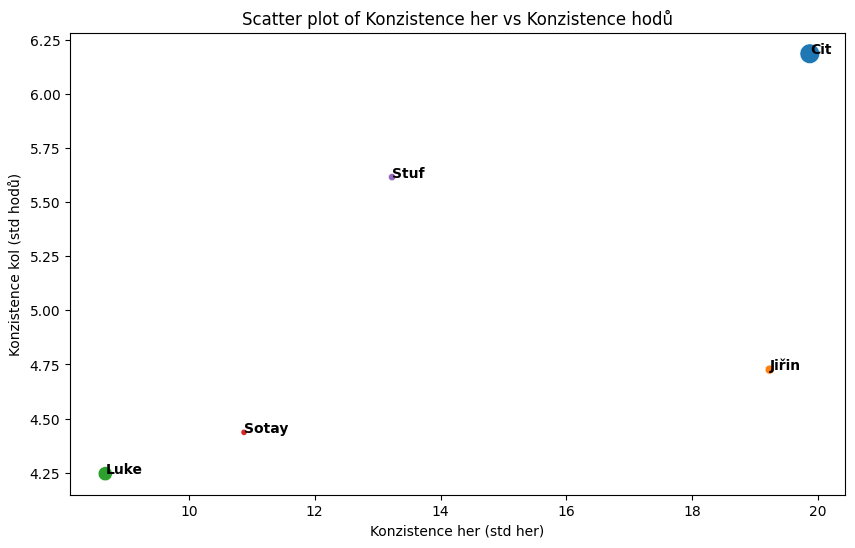

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the plot
plt.figure(figsize=(10, 6))

# Create the scatter plot with player names as labels and different colors
scatter = sns.scatterplot(
    data=player_stats,
    x='total_std', y='throw_std', 
    size='total_mean', 
    hue='Hráč',  # Different colors for each player
    sizes=(20, 200),  # Adjust the range of dot sizes as needed
    legend=False
)

# Label each point with the player name
for i in range(player_stats.shape[0]):
    plt.text(
        player_stats['total_std'][i],
        player_stats['throw_std'][i],
        player_stats['Hráč'][i],
        horizontalalignment='left', size='medium', color='black', weight='semibold'
    )

# Add labels and title
plt.xlabel('Konzistence her (std her)')
plt.ylabel('Konzistence kol (std hodů)')
plt.title('Scatter plot of Konzistence her vs Konzistence hodů')

plt.show()



In [53]:
# Calculate Coefficient of Variation (CoV) for throw_std and total_std
player_stats['throw_CoV'] = player_stats['throw_std'] / player_stats['throw_mean']
player_stats['total_CoV'] = player_stats['total_std'] / player_stats['total_mean']


# Calculate team averages for CoV and adjust values
team_avg_throw_CoV = player_stats['throw_CoV'].mean()
team_avg_total_CoV = player_stats['total_CoV'].mean()

player_stats['adjusted_throw_CoV'] = -player_stats['throw_CoV'] + team_avg_throw_CoV
player_stats['adjusted_total_CoV'] = -player_stats['total_CoV'] + team_avg_total_CoV

player_stats

,Hráč,throw_mean,throw_std,total_mean,total_std,throw_CoV,total_CoV,adjusted_throw_CoV,adjusted_total_CoV
0,Cit,10.550000,6.184795,105.500000,19.867058,0.586237,0.188313,0.069279,-0.002713
1,Jiřin,7.044444,4.726001,70.444444,19.229607,0.670883,0.272975,-0.015368,-0.087375
2,Luke,8.422222,4.245229,84.222222,8.671473,0.504051,0.102959,0.151465,0.082641
3,Sotay,6.540000,4.436445,65.400000,10.876580,0.678355,0.166309,-0.022840,0.019292
4,Stuf,6.700000,5.614943,67.000000,13.228757,0.838051,0.197444,-0.182536,-0.011844


In [54]:
# check
print(player_stats['adjusted_total_CoV'].mean())
print(player_stats['adjusted_throw_CoV'].mean())

2.7755575615628915e-18
4.4408920985006264e-17


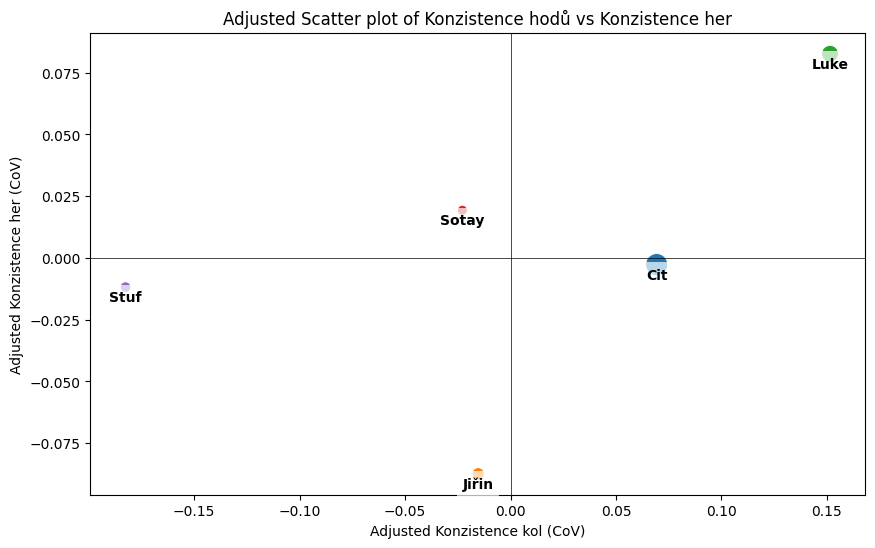

In [55]:
plt.figure(figsize=(10, 6))

# Create the scatter plot with adjusted CoV values, switching the axes
scatter = sns.scatterplot(
    data=player_stats,
    x='adjusted_throw_CoV', y='adjusted_total_CoV',  # Switched axes
    size='total_mean', 
    hue='Hráč',  # Different colors for each player
    sizes=(50, 250),  # Adjust the range of dot sizes as needed
    legend=False
)

# Add horizontal and vertical lines at the center
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

# Label each point with the player name above the dots
for i in range(player_stats.shape[0]):
    plt.text(
        player_stats['adjusted_throw_CoV'][i],
        player_stats['adjusted_total_CoV'][i] - 0.007,  # Offset label slightly above the point
        player_stats['Hráč'][i],
        horizontalalignment='center', verticalalignment='bottom', size='medium', color='black', weight='semibold',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')  # Add background for readability
    )

# Add labels and title with switched descriptions
plt.xlabel('Adjusted Konzistence kol (CoV)')
plt.ylabel('Adjusted Konzistence her (CoV)')
plt.title('Adjusted Scatter plot of Konzistence hodů vs Konzistence her')

plt.show()

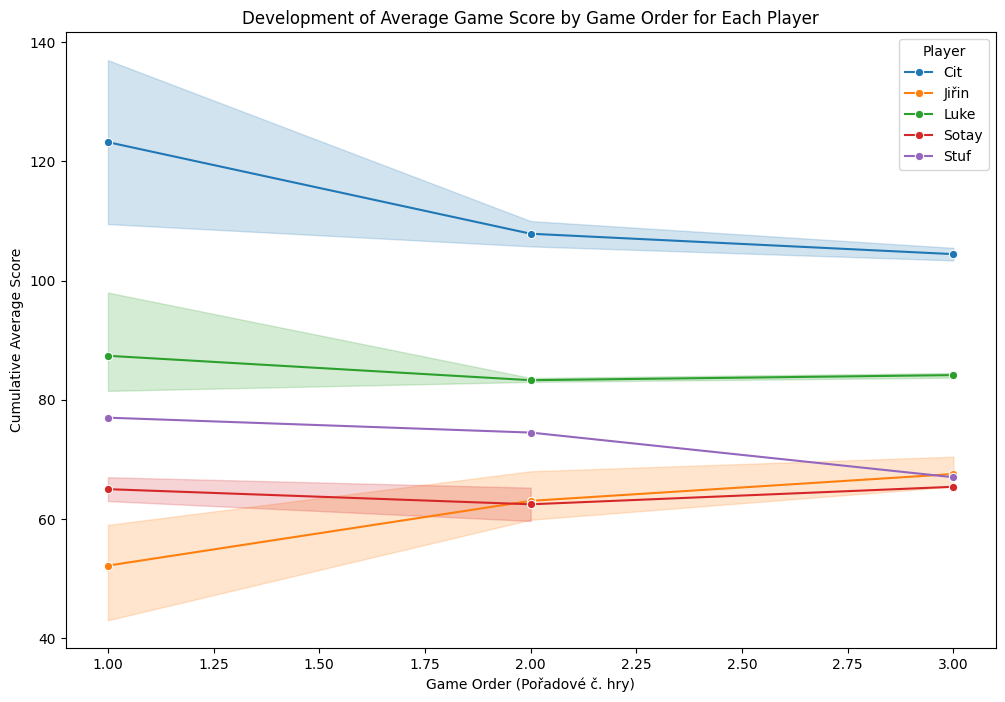

In [56]:
# Sort by player and game order for correct cumulative calculation
df = df.sort_values(by=['Hráč', 'Pořadové č. hry'])

# Calculate cumulative average score for each player based on game order
df['cumulative_avg_score'] = df.groupby('Hráč')['final_score'].expanding().mean().reset_index(level=0, drop=True)

# Plot the cumulative average score for each player using game order as x-axis
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='Pořadové č. hry', y='cumulative_avg_score', hue='Hráč', marker='o')
plt.xlabel('Game Order (Pořadové č. hry)')
plt.ylabel('Cumulative Average Score')
plt.title('Development of Average Game Score by Game Order for Each Player')
plt.legend(title='Player')
plt.show()


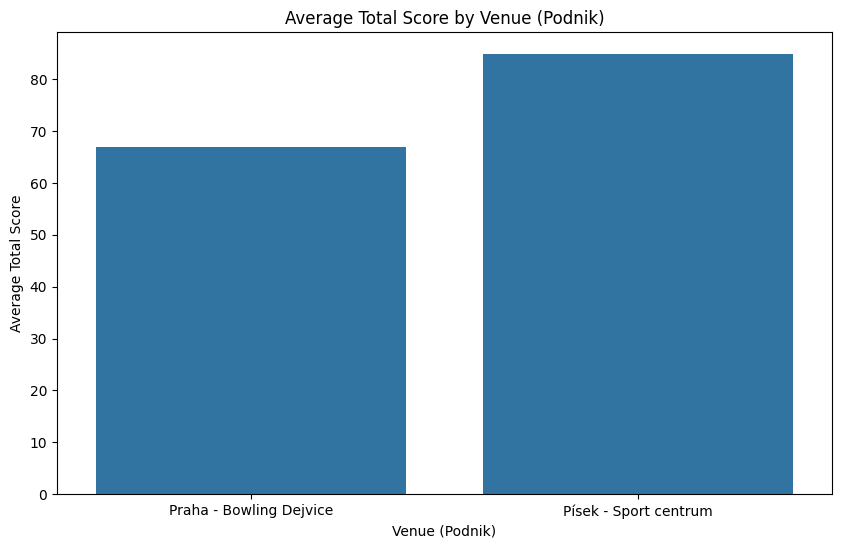

In [57]:
# Calculate the average total score per venue
average_score_per_venue = df.groupby('Podnik')['final_score'].mean().reset_index()

# Plot bar chart for average total score per venue
plt.figure(figsize=(10, 6))
sns.barplot(data=average_score_per_venue, x='Podnik', y='final_score')
plt.xlabel('Venue (Podnik)')
plt.ylabel('Average Total Score')
plt.title('Average Total Score by Venue (Podnik)')
plt.show()


In [58]:
from scipy.stats import skew, kurtosis

# Calculate skewness and kurtosis for each player's final scores
skewness_kurtosis = df.groupby('Hráč')['final_score'].agg(
    skewness=lambda x: skew(x, bias=False),
    kurtosis=lambda x: kurtosis(x, bias=False)
).reset_index()

# Display the skewness and kurtosis values
skewness_kurtosis


,Hráč,skewness,kurtosis
0,Cit,0.617023,-0.208716
1,Jiřin,0.218625,-0.833662
2,Luke,-1.059637,3.657713
3,Sotay,0.780369,1.044360
4,Stuf,-1.457863,-1.500000


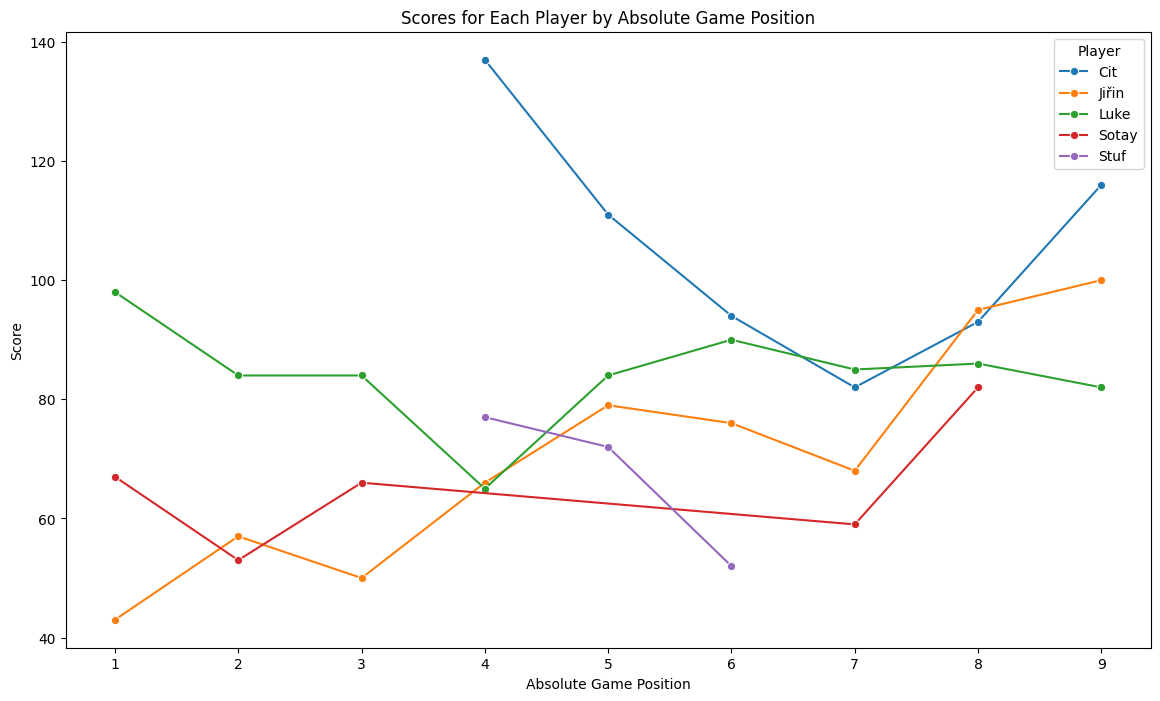

In [59]:
ordered_dates = pd.to_datetime(df['Den'], format='%d/%m/%Y').sort_values().unique()
cumulative_games = 0
games_per_date = {}
for date in ordered_dates:
    date_str = date.strftime('%d/%m/%Y')
    games_today = df[df['Den'] == date_str]['Pořadové č. hry'].max()
    games_per_date[date_str] = cumulative_games
    cumulative_games += games_today

df['absolute_game_position'] = df['Den'].map(games_per_date) + df['Pořadové č. hry']

plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x='absolute_game_position', y='final_score', hue='Hráč', marker='o')
plt.xlabel('Absolute Game Position')
plt.ylabel('Score')
plt.title('Scores for Each Player by Absolute Game Position')
plt.legend(title='Player')
plt.show()

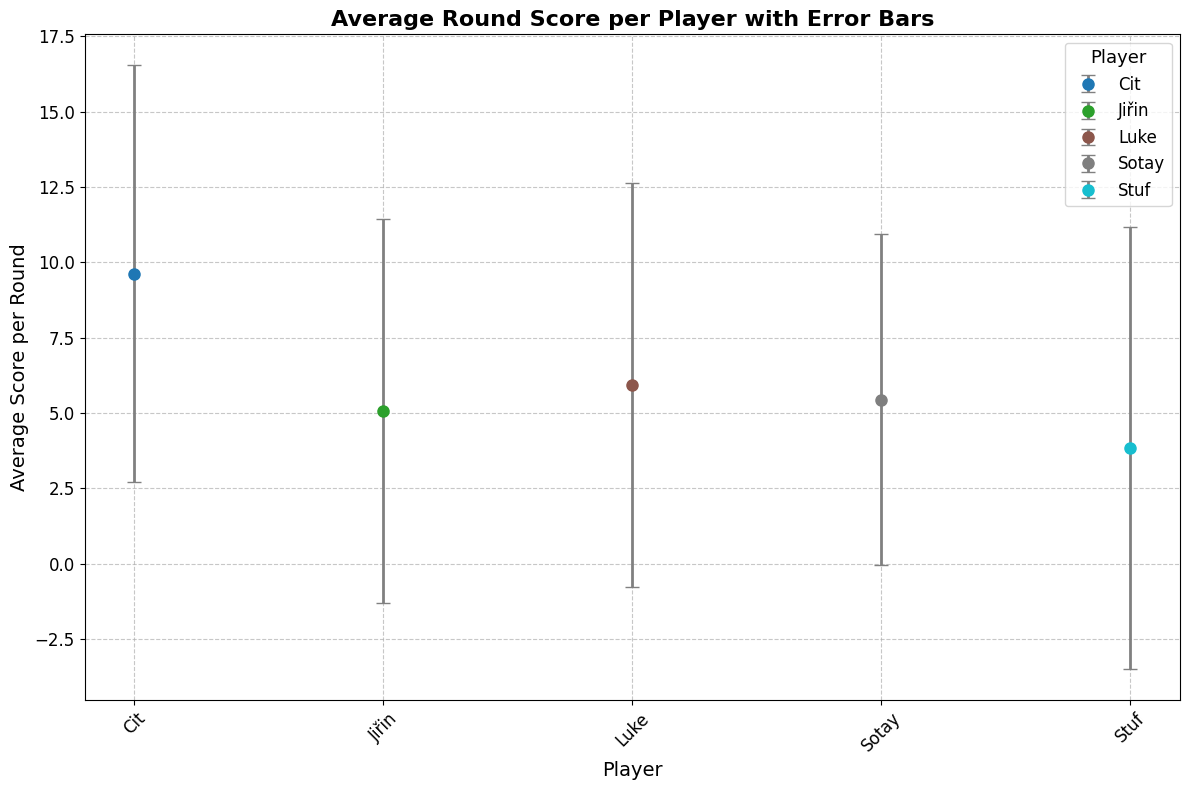

In [60]:
# Columns corresponding to individual round scores
round_columns = [str(i) + '.' for i in range(1, 11)]  # Assuming '1.', '2.', ..., '10.' represent the rounds

# Calculate the average and standard deviation of the round scores per player
df_avg_rounds = df.groupby('Hráč')[round_columns].agg(['mean', 'std']).reset_index()
df_avg_rounds.columns = ['Hráč'] + [f'Round_{i}_mean' for i in range(1, 11)] + [f'Round_{i}_std' for i in range(1, 11)]

# Calculate the overall average and standard deviation across all rounds for each player
df_avg_rounds['Mean_Round_Score'] = df_avg_rounds[[f'Round_{i}_mean' for i in range(1, 11)]].mean(axis=1)
df_avg_rounds['Std_Round_Score'] = df_avg_rounds[[f'Round_{i}_std' for i in range(1, 11)]].mean(axis=1)

# Set up the plot
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(df_avg_rounds)))  # Use a colormap for distinct colors

# Plot with error bars and improved style
for i, player in enumerate(df_avg_rounds['Hráč']):
    plt.errorbar(
        player, 
        df_avg_rounds.loc[i, 'Mean_Round_Score'], 
        yerr=df_avg_rounds.loc[i, 'Std_Round_Score'], 
        fmt='o', 
        capsize=5, 
        color=colors[i], 
        markersize=8, 
        label=player, 
        ecolor='gray', 
        elinewidth=2
    )

# Customize plot appearance
plt.xlabel('Player', fontsize=14)
plt.ylabel('Average Score per Round', fontsize=14)
plt.title('Average Round Score per Player with Error Bars', fontsize=16, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Player', title_fontsize=13, fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()

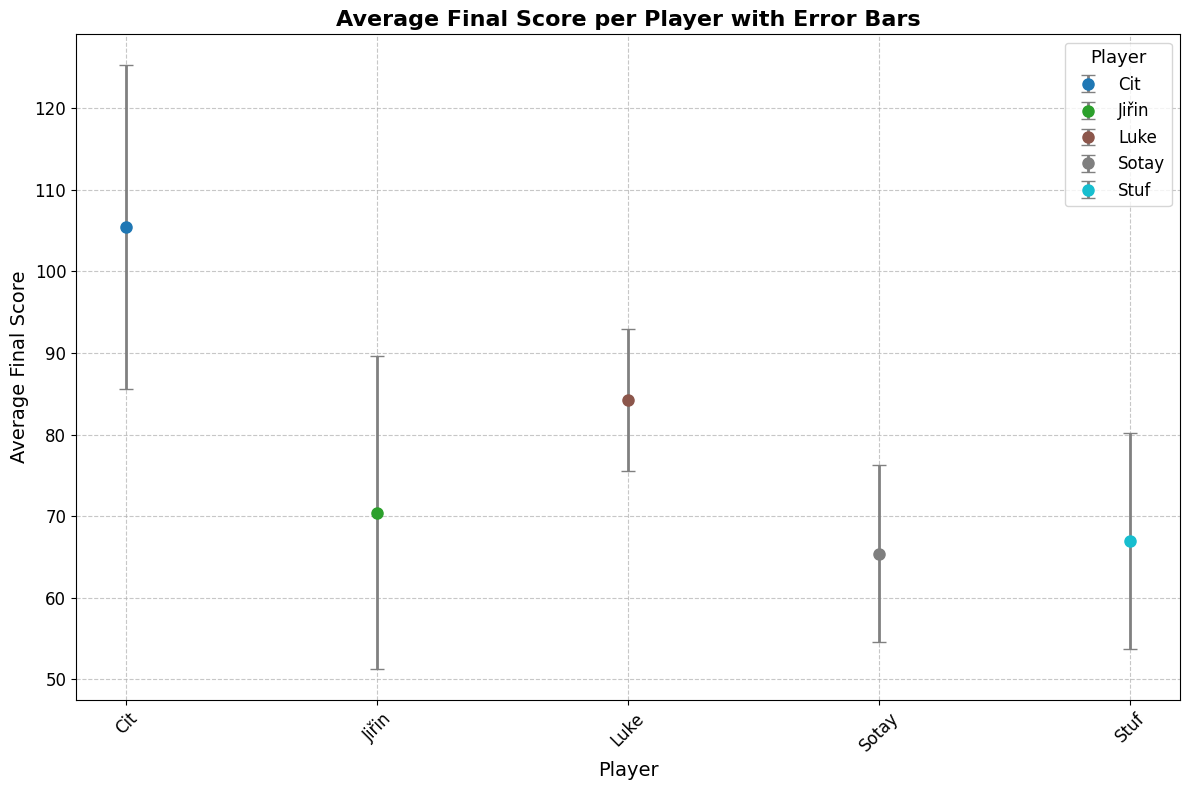

In [61]:
# Calculate the average total (final) score and standard deviation per player
df_final_scores = df.groupby('Hráč')['final_score'].agg(['mean', 'std']).reset_index()
df_final_scores.columns = ['Hráč', 'Mean_Final_Score', 'Std_Dev_Final_Score']

# Set up the plot
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(df_final_scores)))  # Use a colormap for distinct colors

# Plot the average final score with error bars for each player
for i, player in enumerate(df_final_scores['Hráč']):
    plt.errorbar(
        player, 
        df_final_scores.loc[i, 'Mean_Final_Score'], 
        yerr=df_final_scores.loc[i, 'Std_Dev_Final_Score'], 
        fmt='o', 
        capsize=5, 
        color=colors[i], 
        markersize=8, 
        label=player, 
        ecolor='gray', 
        elinewidth=2
    )

# Customize plot appearance
plt.xlabel('Player', fontsize=14)
plt.ylabel('Average Final Score', fontsize=14)
plt.title('Average Final Score per Player with Error Bars', fontsize=16, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Player', title_fontsize=13, fontsize=12, loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()
